# Load and clean gnps spectra

The gnps spectra are downloaded on 24-11-2021 from https://gnps-external.ucsd.edu/gnpslibrary/ALL_GNPS.mgf

The final file created in this notebook, that is used by other notebooks is named: ALL_GNPS_24_11_2021_inchikeys_from_pubchem.pickle 
In this version, the metadata is cleaned, peaks are normalized and cleaned and missing inchikeys were added by using pubchem. 

Other in between files are:
ALL_GNPS_24_11_2021.mgf Containing the raw spectra of GNPS
ALL_GNPS_24_11_2021_raw_spectra.pickle Contains the raw spectra, in pickled matchms spectra.
ALL_GNPS_24_11_2021_cleaned_metadata.pickle Contains spectra with filtered metadata. No spectra or peaks have been removed.
ALL_GNPS_24_11_2021_removed_peaks.pickle In this version peak and spectra were removed that do not fit within certain criteria (see below).

The next step in data preparation is the notebook 2_split_data

In [1]:
import os
root_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/gnps_24_11_2021/in_between_files_clean_gnps_spectra"
path_to_gnps_spectra = os.path.join(root_folder, "ALL_GNPS_24_11_2021.mgf")

In [7]:
from matchms.importing import load_from_mgf
gnps_spectra = list(load_from_mgf(path_to_gnps_spectra))

In [8]:
print(len(gnps_spectra))

480863


Dump spectra in pickle file for quicker loading

In [11]:
import pickle 
pickle.dump(gnps_spectra,
           open(os.path.join(root_folder, "ALL_GNPS_24_11_2021_raw_spectra.pickle"), "wb"))

In [3]:
import pickle
outfile = os.path.join(root_folder, "ALL_GNPS_24_11_2021_raw_spectra.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [20]:
def count_annotations(spectra):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    nr_of_spectra_with_less_than_3_peaks = 0
    nr_of_spectra_with_more_than_500_peaks = 0

    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)
        if len(spec.peaks.mz) < 3:
            nr_of_spectra_with_less_than_3_peaks += 1
        if len(spec.peaks.mz) > 500:
            nr_of_spectra_with_more_than_500_peaks += 1

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("nr_of_spectra:", len(spectra))
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")
    print("Spectra with less than 3 peaks:", nr_of_spectra_with_less_than_3_peaks)
    print("Spectra with more than 500 peaks:", nr_of_spectra_with_more_than_500_peaks)
    

In [5]:
count_annotations(gnps_spectra)

nr_of_spectra: 480863
Inchis: 477239 -- 27333 unique
Smiles: 478738 -- 35046 unique
Inchikeys: 0 -- 0 unique (first 14 characters)


## Clean metadata with matchms
The metadata is cleaned, no spectra are removed in this step. 

In [6]:
from matchms.filtering import default_filters, add_parent_mass, derive_adduct_from_name, \
    harmonize_undefined_inchikey, harmonize_undefined_inchi, harmonize_undefined_smiles, repair_inchi_inchikey_smiles,\
    derive_inchi_from_smiles, derive_smiles_from_inchi, derive_inchikey_from_inchi

def apply_metadata_filters(s):
    # Default filters
    s = default_filters(s)
    s = derive_adduct_from_name(s)
    s = add_parent_mass(s, estimate_from_adduct=True)
    
    # Here, undefiend entries will be harmonized (instead of having a huge variation of None,"", "N/A" etc.)
    s = harmonize_undefined_inchikey(s)
    s = harmonize_undefined_inchi(s)
    s = harmonize_undefined_smiles(s)
    # The repair_inchi_inchikey_smiles function will correct misplaced metadata (e.g. inchikeys entered as inchi etc.) and harmonize the entry strings.
    s = repair_inchi_inchikey_smiles(s)
    # Where possible (and necessary, i.e. missing): Convert between smiles, inchi, inchikey to complete metadata. This is done using functions from rdkit.
    s = derive_inchi_from_smiles(s)
    s = derive_smiles_from_inchi(s)
    s = derive_inchikey_from_inchi(s)
    return s


Block below was rerun, so not all the printed statements are stored in the notebook. 

In [1]:
from tqdm.notebook import tqdm

gnps_spectra = [apply_metadata_filters(s) for s in tqdm(gnps_spectra)]

NameError: name 'gnps_spectra' is not defined

In [9]:
pickle.dump(gnps_spectra,
           open(os.path.join(root_folder, "ALL_GNPS_24_11_2021_cleaned_metadata.pickle"), "wb"))

In [18]:
count_annotations(gnps_spectra)

480863
Inchis: 428302 -- 26823 unique
Smiles: 427897 -- 37735 unique
Inchikeys: 427863 -- 22613 unique (first 14 characters)


# remove spectra based on peaks
- Peaks are normalized
- Peaks with a low relative intensity < 0.001 are removed
- Removes all peaks above 1000 Da are removed
- For spectra with more than 500 peaks, the least intense peaks are removed (until 500 are left)
- Removes all spectra that have < 3 peaks


In [22]:
outfile = os.path.join(root_folder, "ALL_GNPS_24_11_2021_cleaned_metadata.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [23]:
count_annotations(gnps_spectra)

nr_of_spectra: 480863
Inchis: 428302 -- 26823 unique
Smiles: 427897 -- 37735 unique
Inchikeys: 427863 -- 22613 unique (first 14 characters)
Spectra with less than 3 peaks: 76128
Spectra with more than 500 peaks: 19695


In [8]:
import numpy as np
number_of_peaks = np.array([len(s.peaks) for s in gnps_spectra])

Plot spectrum distribution of spectra with small peaks. 

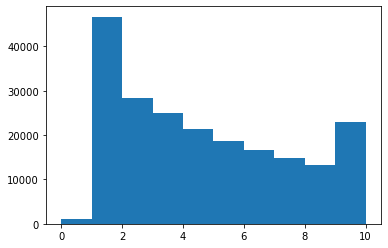

In [9]:
from matplotlib import pyplot as plt
plt.hist(number_of_peaks, np.linspace(0,10,11))
plt.show()

In [10]:
from matplotlib import pyplot as plt 

def plot_nr_of_peaks_distribution(spectra):
    peak_list = []
    for spectrum in spectra:
        nr_of_peaks = len(spectrum.peaks)
        peak_list.append(nr_of_peaks)
    plt.hist(peak_list)
    plt.show()

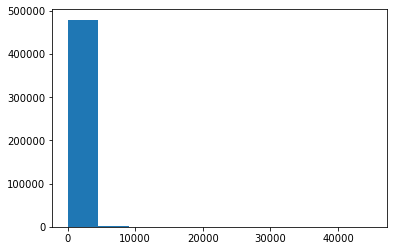

In [11]:
plot_nr_of_peaks_distribution(gnps_spectra)

In [12]:
print(f"{np.sum(number_of_peaks < 5)} spectra have < 5 peaks")

122392 spectra have < 5 peaks


In [13]:
from matchms.filtering import select_by_mz, normalize_intensities, require_minimum_number_of_peaks, select_by_relative_intensity, reduce_to_number_of_peaks

def normalize_and_filter_peaks(spectrum):
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, 0.001, 1)
    spectrum = select_by_mz(spectrum, mz_from=0.0, mz_to=1000.0)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max = 500)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=3)
    return spectrum

In [14]:
from tqdm.notebook import tqdm

gnps_spectra = [normalize_and_filter_peaks(s) for s in tqdm(gnps_spectra)]

  0%|          | 0/480863 [00:00<?, ?it/s]

In [21]:
gnps_spectra = [s for s in gnps_spectra if s is not None]
count_annotations(gnps_spectra)

nr_of_spectra: 403344
Inchis: 351258 -- 26432 unique
Smiles: 350852 -- 36829 unique
Inchikeys: 350819 -- 22347 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


In [23]:
pickle.dump(gnps_spectra,
           open(os.path.join(root_folder, "ALL_GNPS_24_11_2021_removed_peaks.pickle"), "wb"))

In [31]:
plot_nr_of_peaks_distribution(gnps_spectra)

# Use pubchem to add missing inchikeys
52561 spectra do not have a inchikey. 

In [1]:
import pickle
import os
root_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/gnps_24_11_2021"
outfile = os.path.join(root_folder, "ALL_GNPS_24_11_2021_removed_peaks.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [3]:
count_annotations(gnps_spectra)

nr_of_spectra: 403840
Inchis: 351753 -- 26434 unique
Smiles: 351347 -- 36832 unique
Inchikeys: 351314 -- 22349 unique (first 14 characters)


### Select spectra that have no inchikey or smiles:

In [28]:
spectra_with_missing_inchi_or_smiles = []
for spectrum in gnps_spectra:
    inchikey = spectrum.get("inchikey") 
    if inchikey is None or len(inchikey) < 14:
        spectra_with_missing_inchi_or_smiles.append(spectrum)
    else:
        smiles = spectrum.get("smiles")
        if smiles is None or len(smiles) < 1:
            spectra_with_missing_inchi_or_smiles.append(spectrum)
print(len(spectra_with_missing_inchi_or_smiles))

52532


In [29]:
count_annotations(spectra_with_missing_inchi_or_smiles)

nr_of_spectra: 52532
Inchis: 445 -- 102 unique
Smiles: 39 -- 33 unique
Inchikeys: 6 -- 4 unique (first 14 characters)


In [6]:
from matchmsextras.pubchem_lookup import pubchem_metadata_lookup
from tqdm.notebook import tqdm

gnps_spectra_annotated_with_pubchem = []
for i, s in enumerate(tqdm(gnps_spectra)):
    gnps_spectra_annotated_with_pubchem.append(pubchem_metadata_lookup(s, name_search_depth=10))

  0%|          | 0/403840 [00:00<?, ?it/s]

Matching molecular weight (269.2 vs parent mass of 269.0)
Matching compound name: 2-nonenyl 4-quinolone
Matching molecular weight (271.2 vs parent mass of 271.0)
Matching compound name: 2-nonyl 4-quinolone
Matching molecular weight (412.0 vs parent mass of 410.0)
Matching compound name: Deoxyprepacifenol
Matching molecular weight (412.0 vs parent mass of 410.0)
Matching compound name: Deoxyprepacifenol
Matching molecular weight (290.2 vs parent mass of 290.2)
Matching compound name: Ecklonialactone A
Matching molecular weight (290.2 vs parent mass of 290.2)
Matching compound name: Ecklonialactone A
Matching molecular weight (197.2 vs parent mass of 197.2)
Matching compound name: N-methylundec-10-enamide
Matching molecular weight (337.3 vs parent mass of 337.3)
Matching compound name: Palmyrolide A
Matching molecular weight (1531.8 vs parent mass of 1531.8)
Matching compound name: Portoamide A
Matching molecular weight (1531.8 vs parent mass of 1531.8)
Matching compound name: Portoamide

Matching molecular weight (415.3 vs parent mass of 415.9)
Matching compound name: Piericidin A
Matching molecular weight (257.1 vs parent mass of 257.6)
Matching compound name: Indolmycin
Matching molecular weight (182.1 vs parent mass of 182.1)
Matching compound name: 3-ethyl-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione
Matching molecular weight (1639.6 vs parent mass of 1639.0)
Matching compound name: Taromycin A
Matching molecular weight (369.1 vs parent mass of 369.0)
Matching compound name: Ochratoxin B
Matching molecular weight (779.3 vs parent mass of 779.0)
Matching compound name: Fusigen
Matching molecular weight (438.1 vs parent mass of 438.0)
Matching compound name: Kotanin
Matching molecular weight (705.4 vs parent mass of 705.0)
Matching compound name: Fumonisin B2
Matching molecular weight (510.2 vs parent mass of 510.0)
Matching compound name: Territrem A
Matching molecular weight (808.3 vs parent mass of 808.3)
Matching compound name: Arenimycin B
Matching mol

KeyboardInterrupt: 

In [ ]:
pickle.dump(gnps_spectra_annotated_with_pubchem,
           open(os.path.join(root_folder, "ALL_GNPS_24_11_2021_inchikeys_from_pubchem.pickle"), "wb"))

In [ ]:
count_annotations(gnps_spectra_annotated_with_pubchem)

# Checks that do not change the spectra
Checks were performed to make sure the compound names and formulas were indeed formatted in the right way

In [3]:
import pickle
import os
root_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/gnps_24_11_2021"
outfile = os.path.join(root_folder, "ALL_GNPS_24_11_2021_cleaned_by_matchm.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [4]:
formulas = []
name_to_formulas = []
for spec in gnps_spectra:
    if spec.get("formula"):
        formulas.append(spec.get("formula"))
        name_to_formulas.append(spec.get("compound_name") + "---" + spec.get("formula"))

In [5]:
print(name_to_formulas[:10])

['Putative amphotericin-related---C48H77NO17', '---HNP1', '---C16H25NS', '---C16H25NS', '---C16H25NS', '---C16H25NS', 'PC(16:1/0:0);---C24H49N1O7P1', 'PC(16:1/0:0);---C24H49N1O7P1', 'PC(18:2/0:0);---C26H51N1O7P1', 'PC(18:2/0:0);---C26H51N1O7P1']


In [10]:
for spectrum in gnps_spectra[:1000]:
    inchikey = spectrum.get("inchikey")
    if inchikey is None:
        inchikey = spectrum.get("inchikey_inchi")
    if inchikey is None or len(inchikey) < 13:
        print(spectrum.get("compound_name"))

Salinisporamide A
Halimide B
Halimide B
Orellin B
unpublished peptide from CNL 643
unpublished peptide from CNL 643
unpublished peptide11M4
Glucopiericidin
Glucopiericidin
unpublished ME5.F6
Malyngamide C acetate
Microsporin C
Microsporin C
Stypoltrione
hydrated Cyanosporaside B
Salinisporazine A
Salinisporazine A
Actinoquinolone A
Actinoquinolone A
Sagitol B (Putative Analogue)
Sagitol B (Putative Analogue)
8-Desoxyrifamycin W
8-desoxyenterocin
Ammosamide
Ammosamide
BouillonamideB
Arenimycin A
Arenimycin A
BouillonamideB
7-OH-staurosporine
Antillatoxin B (red)
Bouillonamide B
Somocystinamide_A_byproduct
Janthielamide
Janthielamide
Dilophic_acid_methyl_ester
Dilophic_acid_methyl_ester
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_triacetate
Hoiamide_A_triacetate
Hoiamide_A_triacetate
Hoiamide_A_triacetate MS34+Na
Kalkitoxin_thioamide_alcohol
Kalkitoxin_thioamide_alcohol
Trp_